# **Transfer Learning**

**Goal**: Using punlicly available image classification model and alter it to meet our needs, vastly improving both training speed and model performance.

**Objectives**

- Load data.
- Download a pre-trained model.
- Alter that model to suit our needs with Transfer Learning.
- Train just the altered part.
- Test model performance with K-fold cross-validation.

In [16]:
import os 

import matplotlib
import matplotlib.pyplot as plt 
import numpy as np 
import sklearn.model_selection
import torch
import torch.nn as nn 
import torch.optim as optim
import torchinfo
import torchvision
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torch.utils.data import DataLoader
from torchinfo import summary
from torchvision import datasets, transforms
from tqdm import tqdm

In [17]:
print("torch version : ", torch.__version__)
print("torchvision version : ", torchvision.__version__)
print("torchinfo version : ", torchinfo.__version__)
print("numpy version : ", np.__version__)
print("matplotlib version : ", matplotlib.__version__)

!python --version

torch version :  2.5.1+cpu
torchvision version :  0.20.1+cpu
torchinfo version :  1.8.0
numpy version :  1.26.3
matplotlib version :  3.8.3
Python 3.12.1


In [18]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cpu device.


**1. Loading Data**

In [19]:
data_dir = os.path.join("data_p2", "data_undersampled", "train")

print("Data directory:", data_dir)

Data directory: data_p2\data_undersampled\train


Convert to RGB

In [20]:
class ConvertToRGB(object):
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

Data Transformation Setup

In [21]:
transform_normalized = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((224, 224)),
        # Convert images to tensors
        transforms.ToTensor(),
        transforms.Normalize(
            mean = [0.4326, 0.4953, 0.3120], std = [0.2178, 0.2214, 0.2091]
        )
        
    ]
)
transform_normalized

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.4326, 0.4953, 0.312], std=[0.2178, 0.2214, 0.2091])
)

ImageFolder Application

In [22]:
dataset = datasets.ImageFolder(data_dir, transform_normalized)

dataset

Dataset ImageFolder
    Number of datapoints: 8180
    Root location: data_p2\data_undersampled\train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.4326, 0.4953, 0.312], std=[0.2178, 0.2214, 0.2091])
           )

In [23]:
classes = dataset.classes
classes

['cassava-bacterial-blight-cbb',
 'cassava-brown-streak-disease-cbsd',
 'cassava-green-mottle-cgm',
 'cassava-healthy',
 'cassava-mosaic-disease-cmd']

Class Balance Clarifiaction

In [24]:
from training import class_counts

In [25]:
counts = class_counts(dataset)
counts

  0%|          | 0/8180 [00:00<?, ?it/s]

cassava-bacterial-blight-cbb         1087
cassava-brown-streak-disease-cbsd    1622
cassava-green-mottle-cgm             1682
cassava-healthy                      1708
cassava-mosaic-disease-cmd           2081
dtype: int64

DataLoader Creation

In [26]:
batch_size = 32
dataset_loader = DataLoader(dataset, batch_size)

print(f"Batch shape: {next(iter(dataset_loader))[0].shape}")

Batch shape: torch.Size([32, 3, 224, 224])


**2. Implementing Transfer Learning**

In [27]:
model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\Asus/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [04:22<00:00, 391kB/s] 


In [28]:
test_batch = next(iter(dataset_loader))[0]
batch_shape = test_batch.shape

# Create the model summary
summary(model, input_size=batch_shape)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 1000]                --
├─Conv2d: 1-1                            [32, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [32, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          4,096
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]          --
│ 

Model Weights.

In [29]:
next(model.parameters())

Parameter containing:
tensor([[[[-7.4457e-03, -3.1783e-03,  3.7353e-02,  ...,  4.7936e-02,
           -2.0325e-02,  8.8140e-03],
          [-5.7435e-02,  4.4709e-02,  7.7509e-02,  ...,  8.8442e-02,
            2.9346e-02, -5.8331e-02],
          [ 6.8356e-02, -2.7044e-01,  4.0348e-01,  ..., -1.6491e-01,
            2.1868e-01, -7.2909e-02],
          ...,
          [-1.0874e-01,  3.8148e-01, -4.5487e-01,  ...,  6.8366e-01,
           -5.7855e-01,  2.2461e-01],
          [ 2.5698e-02, -1.7703e-01,  6.4375e-01,  ...,  5.2644e-01,
           -4.9317e-02, -6.8082e-02],
          [ 4.5281e-02, -1.3072e-01,  1.7864e-02,  ..., -3.5753e-01,
            1.8976e-01, -2.2302e-02]],

         [[ 8.9197e-03,  4.8768e-03, -1.5356e-02,  ...,  8.6949e-02,
           -6.5541e-02,  1.6895e-02],
          [-3.3543e-02,  3.9067e-02,  8.6565e-02,  ...,  1.1713e-01,
            2.1848e-02, -4.4082e-02],
          [ 5.5285e-02, -2.6424e-01,  4.2687e-01,  ..., -2.3723e-01,
            3.2017e-01, -1.1832e-01]

Turn of model weight tuning.

In [30]:
for params in model.parameters():
    params.requires_grad = False

Model and Batch Transfer

In [31]:
# Move the model to device
model.to(device)

# Move our test_batch to device
test_batch_cuda = test_batch.to(device)

print("Test batch is running on:", test_batch_cuda.device)

Test batch is running on: cpu


Output shape check.

In [32]:
model_test_out = model(test_batch_cuda)
model_test_shape = model_test_out.shape

print("Output shape:", model_test_shape)

Output shape: torch.Size([32, 1000])


**3. Modifying the Network to Our Task**

This model was meant for a task with 1000 classes. We only have 5, so that's not going to work for us.

last element:

In [33]:
list(model.named_modules())[-1]

('fc', Linear(in_features=2048, out_features=1000, bias=True))

- It's a linear layer with 1000 neurons (and hence outputs)

-  Get the number of input features into the last layer by using in_features attribute. Save that to the in_features variable.

In [34]:
in_features = model.fc.in_features
in_features

2048

Linear Layer Addition.

We'll make a small network to do our classification. As before, we'll build it with the Sequential container.

In [35]:
classifier = torch.nn.Sequential()

We'll build up a network with the following structure

- Linear layer of 256 neurons
- ReLU
- Dropout
- Linear layer of 5 neurons for output

In [36]:
classification_layer = torch.nn.Linear(in_features, out_features=256)


# Add the layer to our classifier
classifier.append(classification_layer)

Sequential(
  (0): Linear(in_features=2048, out_features=256, bias=True)
)

In [37]:
classifier.append(torch.nn.ReLU())
classifier.append(torch.nn.Dropout())

Sequential(
  (0): Linear(in_features=2048, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
)

In [38]:
output_layer = torch.nn.Linear(in_features=256, out_features=5)

# Add the layer to our classifier
classifier.append(output_layer)

Sequential(
  (0): Linear(in_features=2048, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=256, out_features=5, bias=True)
)

In [39]:
model.fc = classifier

Model Summary

In [40]:
# Create the model summary
summary(model, input_size=batch_shape)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 5]                   --
├─Conv2d: 1-1                            [32, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        (128)
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [32, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          (4,096)
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          (36,864)
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]   

**4. K-fold Cross-Validation**

In [42]:
k = 5

kfold_splitter = sklearn.model_selection.KFold(n_splits=k, shuffle=True, random_state=42)

train_nums, val_nums = next(kfold_splitter.split(range(100)))
fold_fraction = len(val_nums) / (len(train_nums) + len(val_nums))
print(f"One fold is {100*fold_fraction:.2f}%")

One fold is 20.00%


In [41]:
from training import predict, train

Loss and Optimizer

In [43]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [44]:
model.fc

Sequential(
  (0): Linear(in_features=2048, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=256, out_features=5, bias=True)
)

In [45]:
def reset_classifier(model):
    model.fc.get_submodule("0").reset_parameters()
    model.fc.get_submodule("3").reset_parameters()

In [46]:
num_epochs = 6

In [47]:
# you can safely skip this cell and load the model in the next cell

training_records = {}
fold_count = 0

for train_idx, val_idx in kfold_splitter.split(np.arange(len(dataset))):
    fold_count += 1
    print("*****Fold {}*****".format(fold_count))

    # Make train and validation data loaders
    train_dataset = torch.utils.data.Subset(dataset, train_idx)
    val_dataset = torch.utils.data.Subset(dataset, val_idx)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Reset the model
    reset_classifier(model)

    # Train
    train_losses, val_losses, train_accuracies, val_accuracies = train(
        model,
        optimizer,
        loss_fn,
        train_loader,
        val_loader,
        epochs=num_epochs,
        device=device,
        use_train_accuracy=False,
    )

    # Save training results for graphing
    training_records[fold_count] = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies,
    }

    print("\n\n")

*****Fold 1*****


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Scoring:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 1
    Training loss: 1.23
    Validation loss: 1.02
    Validation accuracy: 0.59


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Scoring:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 2
    Training loss: 1.05
    Validation loss: 0.96
    Validation accuracy: 0.60


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Scoring:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 3
    Training loss: 0.96
    Validation loss: 0.95
    Validation accuracy: 0.62


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Scoring:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 4
    Training loss: 0.90
    Validation loss: 0.93
    Validation accuracy: 0.61


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Scoring:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 5
    Training loss: 0.85
    Validation loss: 0.94
    Validation accuracy: 0.61


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Scoring:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 6
    Training loss: 0.83
    Validation loss: 0.93
    Validation accuracy: 0.63



*****Fold 2*****


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Scoring:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 1
    Training loss: 1.24
    Validation loss: 1.06
    Validation accuracy: 0.55


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Scoring:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 2
    Training loss: 1.04
    Validation loss: 0.97
    Validation accuracy: 0.60


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Scoring:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 3
    Training loss: 0.96
    Validation loss: 0.93
    Validation accuracy: 0.61


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Scoring:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 4
    Training loss: 0.91
    Validation loss: 0.95
    Validation accuracy: 0.60


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Scoring:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 5
    Training loss: 0.86
    Validation loss: 0.92
    Validation accuracy: 0.63


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Scoring:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 6
    Training loss: 0.81
    Validation loss: 0.95
    Validation accuracy: 0.61



*****Fold 3*****


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Scoring:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 1
    Training loss: 1.24
    Validation loss: 1.05
    Validation accuracy: 0.57


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Scoring:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 2
    Training loss: 1.04
    Validation loss: 0.98
    Validation accuracy: 0.61


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Scoring:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 3
    Training loss: 0.96
    Validation loss: 0.97
    Validation accuracy: 0.61


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Scoring:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 4
    Training loss: 0.90
    Validation loss: 0.96
    Validation accuracy: 0.62


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Scoring:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 5
    Training loss: 0.86
    Validation loss: 0.95
    Validation accuracy: 0.61


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Scoring:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 6
    Training loss: 0.81
    Validation loss: 0.97
    Validation accuracy: 0.61



*****Fold 4*****


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Scoring:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 1
    Training loss: 1.24
    Validation loss: 1.04
    Validation accuracy: 0.58


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Scoring:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 2
    Training loss: 1.05
    Validation loss: 1.01
    Validation accuracy: 0.57


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Scoring:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 3
    Training loss: 0.95
    Validation loss: 0.96
    Validation accuracy: 0.62


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Scoring:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 4
    Training loss: 0.90
    Validation loss: 0.95
    Validation accuracy: 0.61


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Scoring:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 5
    Training loss: 0.86
    Validation loss: 0.96
    Validation accuracy: 0.61


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Scoring:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 6
    Training loss: 0.82
    Validation loss: 0.97
    Validation accuracy: 0.61



*****Fold 5*****


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Scoring:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 1
    Training loss: 1.23
    Validation loss: 1.04
    Validation accuracy: 0.56


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Scoring:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 2
    Training loss: 1.03
    Validation loss: 1.01
    Validation accuracy: 0.58


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Scoring:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 3
    Training loss: 0.95
    Validation loss: 0.99
    Validation accuracy: 0.60


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Scoring:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 4
    Training loss: 0.89
    Validation loss: 0.96
    Validation accuracy: 0.61


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Scoring:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 5
    Training loss: 0.85
    Validation loss: 0.97
    Validation accuracy: 0.60


Training:   0%|          | 0/205 [00:00<?, ?it/s]

Scoring:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 6
    Training loss: 0.80
    Validation loss: 0.97
    Validation accuracy: 0.61





In [ ]:
model = torch.load("pretrained_model.pth", weights_only=False)
model.to(device)

In [ ]:
import pickle
with open('training_records.pkl', 'rb') as fp:
    training_records = pickle.load(fp)

**5. Model Performance**

In [51]:
print(type(training_records))
training_records.keys()

<class 'dict'>


dict_keys([1, 2, 3, 4, 5])

In [52]:
print(type(training_records[1]))
training_records[1].keys()

<class 'dict'>


dict_keys(['train_losses', 'val_losses', 'val_accuracies'])

In [53]:
training_records[1]["train_losses"]

[1.231832902122535,
 1.0452093611719555,
 0.9612180361829352,
 0.9033825831774686,
 0.85170259408671,
 0.833134516089936]

In [54]:
def plot_all_folds(data, measurement):
    for fold in data.keys():
        plt.plot(data[fold][measurement], label=f"Fold {fold}, {measurement}")
    plt.xlabel("Epochs")
    plt.legend()

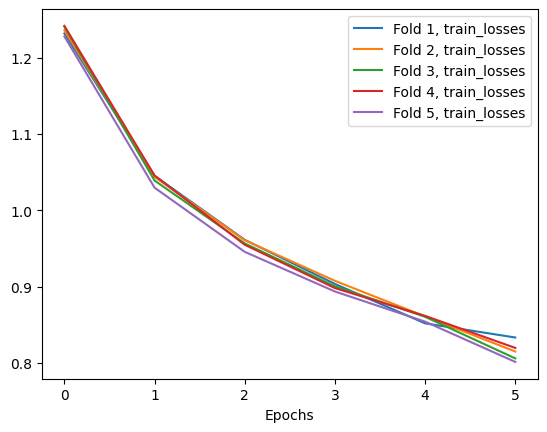

In [55]:
plot_all_folds(training_records, "train_losses")

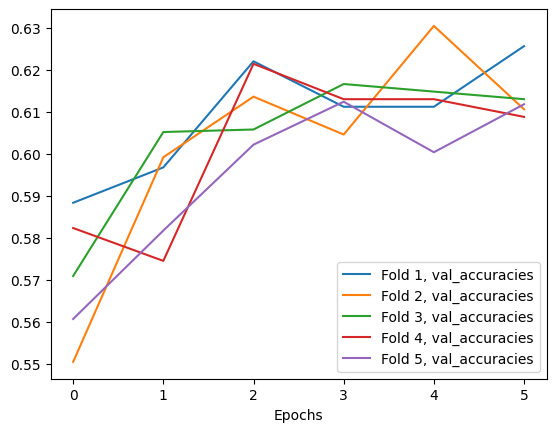

In [56]:
# Plot the validation accuracies
plot_all_folds(training_records, "val_accuracies")

In [ ]:
def fold_average(data, measurement):
    return np.mean([data[fold][measurement][-1] for fold in data])


for measurement in training_records[1].keys():
    avg_measure = fold_average(training_records, measurement)
    print(f"Averaged {measurement}: {avg_measure}")

In [ ]:
# If you loaded the pre-trained model, make sure you have the correct validation set
_, val_idx = list(kfold_splitter.split(np.arange(len(dataset))))[-1]
val_dataset = torch.utils.data.Subset(dataset, val_idx)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [ ]:
targets = []

for _, labels in tqdm(val_loader):
    targets.extend(labels.tolist())

In [ ]:
cm = confusion_matrix(targets, predictions.cpu())

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
plt.show();